## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [1]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

# load in the data
train_data = pd.read_csv('./training.csv', index_col=0)
train_data.head()

,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
ID,,,,,,,,,
1,No,0,2,30.443518,-1.165083,1,1,3,2
3,No,0,3,32.159350,-0.645617,2,3,2,2
4,No,0,2,30.431659,0.133583,1,1,4,2
5,No,0,0,26.588914,-0.212728,2,1,4,2
8,Yes,0,3,28.044331,-0.385883,1,1,2,2


## Check All data 

Using the Pandas Profiling library we can check most of the information we need to see before running any tests or building models. 

In [7]:
# profile = ProfileReport(train_data, title="Pandas Profiling Report")

# profile.to_file("data_report.html")

Summarize dataset:  57%|█████▋    | 13/23 [00:03<00:01,  9.82it/s, Calculate kendall correlation] /home/derricklewis/anaconda3/envs/edaENV/lib/python3.9/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
Export report to file: 100%|██████████| 1/1 [00:00<00:00, 342.53it/s]


In [8]:
# profile

Udacity instance too slow to install the package. 

## Check the invariant metric

We need to be certain that each group in the experiment is similar in size and not outside of a statisitical signifcance. 

In [2]:
promo, control = train_data.Promotion.value_counts()

In [3]:
print("Promo: ", promo)
print("Control: ", control)

Promo:  42364
Control:  42170


As a quick check we can see that the two groups are similar. However, we will take the time to test a normal distribution method to get an exact p-value. 

In [4]:
# get number of trials and number of 'successes'
n_obs = train_data.shape[0]
n_control = train_data.groupby('Promotion').size()[0]

In [5]:
# # simulate outcomes under null, compare to observed outcome
p = 0.5
n_trials = 200_000

samples = np.random.binomial(n_obs, p, n_trials)

print(np.logical_or(samples <= n_control, samples >= (n_obs - n_control)).mean())

0.505335


## Get IRR

In [6]:
# Get probability of purchase with the promotion
promotion_group = train_data.loc[train_data['Promotion'] == 'Yes']
prob_promo = promotion_group['purchase'].mean()

In [7]:
# Get probability of purchase in the control group
control_group = train_data[train_data.Promotion == 'No']
prob_control = control_group['purchase'].mean()

In [8]:
irr = prob_promo - prob_control
irr

0.009454547819772702

Build this into a reusable function

In [9]:
def get_irr(df, invariant, evaluation):
    """
    Create the Incremental Response Rate to the promotion.
    
    INPUT: df = Pandas DataFrame - with data regarding groups and eval metrics
           invariant = String - Column name of the invariant metric in the DataFrame
           evaluation = String - Column name of the evaluation metric in the DataFrame
    
    OUTPUT: Float with the percentage change in the reponse rate of the users in the
            experiment group. 
    """
    experiment = df.loc[df[invariant] == 'Yes']
    prob_exper = experiment[evaluation].mean()
    
    control = df.loc[df[invariant] == 'No']
    prob_control = control[evaluation].mean()
    
    return prob_exper - prob_control
    

In [10]:
get_irr(train_data, 'Promotion', 'purchase')

0.009454547819772702

## Get NIR

In [11]:
promo_pur = len(promotion_group.loc[promotion_group['purchase']==1])
contr_pur = len(control_group.loc[control_group['purchase']==1])

NIR = (10 * promo_pur) - (0.15 * len(promotion_group)) - (10 * contr_pur)
print(NIR)

-2334.5999999999995


In [12]:
def get_nir(df, invariant, evaluation, rev, cost):
    """
    Return Net Incremental Revenue for the promotion. 
    
    INPUT:
        df = pandas dataframe with invariant and evaluation metric
        invariant = String - Column name of the invariant metric in the DataFrame
        evaluation = String - Column name of the evaluation metric in the DataFrame
        rev = integer representing the revenue gained on the purchase
        cost = float representing the cost of the promotion to the experiment group
        
    Output: 
        Dollar value representing the net revenue balancing the promotional costs with the 
        gained revenue from the promotion
    """
    experiment = df.loc[df[invariant] == 'Yes']
    control = df.loc[df[invariant] == 'No']
    experi_pur = len(experiment.loc[experiment[evaluation]==1])
    contr_pur = len(control.loc[control[evaluation]==1])
    
    return (rev * experi_pur) - (cost * len(experiment)) - (rev * contr_pur)


In [13]:
get_nir(train_data, 'Promotion', 'purchase', 10, .15)

-2334.5999999999995

In [ ]:
# sns.pairplot(train_data.drop('purchase', axis=1), kind='reg',diag_kind="kde")

Udacity instance too slow to plot a pairplot. 

In [16]:
def permtest(df, n_trials = 10000):
    """
    Compute a confidence interval for the irr and nir using a permutation method. 
    
    Input parameters:
        df: original dataframe on which to perform the test
        alternative: type of test to perform, {'less', 'greater'}
        n_trials: number of permutation trials to perform
    
    Output value:
        a confidence interval containing 95% of values
    """
    
    
    # initialize storage of permuted irr and nir
    sample_irr = []
    sample_nir = []
    
    # For each trial...
    for _ in range(n_trials):
        # randomly permute the grouping labels
        df.Promotion = np.random.permutation(df.Promotion)
        
        # compute the irr and nir on the permuted dataset
        irr = get_irr(df, 'Promotion', 'purchase')
        nir = get_nir(df, 'Promotion', 'purchase', 10, .15)
        
        # and add the value to the list of samples
        sample_irr.append(irr)
        sample_nir.append(nir)
    
    irr_ci = []
    irr_ci.append(np.percentile(np.array(sample_irr),0.025))
    irr_ci.append(np.percentile(np.array(sample_irr),0.975))
    nir_ci = []
    nir_ci.append(np.percentile(np.array(sample_nir),0.025))
    nir_ci.append(np.percentile(np.array(sample_nir),0.975))
    
    return irr_ci, nir_ci

In [17]:
irr_ci, nir_ci = permtest(train_data, n_trials = 1000)
irr_ci, nir_ci

([-0.002410622201509476, -0.001807252331034754],
 [-7349.624999999999, -7094.599999999999])

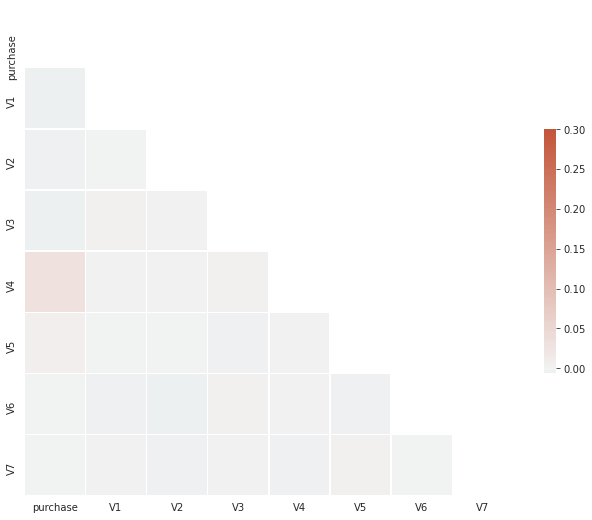

In [18]:
# Compute the correlation matrix
corr = train_data.drop('Promotion', axis=1).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

## Random Forest Classifier

Test a tree based classification on the the unchanged data. 

In [19]:
X = train_data.iloc[:,2:]
y = train_data['purchase']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.02)

forest = RandomForestClassifier(random_state=42, max_depth=4)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

print('The accuracy is {} but the F-1 score is {}'.format(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)))


The accuracy is 0.9905381431105854 but the F-1 score is 0.0


**Results**

While accuracy is high, the predictions are terrible. The class imbalance here is causing the algorithm to choose the false every time. 

**Next steps** 

I could attempt to resample the data to account for the class imbalance with something like the imblearn SMOTE library. Or I could use some of the tuning options and more robust XGBoost algrithm. 

In [95]:
# fit xgboost on an imbalanced classification dataset
from collections import Counter
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import xgboost
# generate dataset

In [75]:
# count examples in each class
counter = Counter(y)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 80.283


In [99]:
model = XGBClassifier(use_label_encoder=False)

In [111]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

In [113]:
param_grid = {
    'learning_rate':[.01, .001],
    'scale_pos_weight':[80],
    "min_child_weight" : [ 1, 3, 5, 7 ],
    "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
    "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]}

In [114]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv)# , scoring='roc_auc')

In [115]:
grid_result = grid.fit(X, y)

[23:15:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [116]:
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.633201 using {'colsample_bytree': 0.5, 'gamma': 0.4, 'learning_rate': 0.01, 'min_child_weight': 1, 'scale_pos_weight': 80}


In [117]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    

    purchase = grid.predict(df)
    
    promotion = pd.Series(purchase).replace({0:'No', 1:'Yes'})

    return promotion

In [118]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0192.

Your nir with this strategy is 324.25.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?
/home/derricklewis/anaconda3/envs/edaENV/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.019214714634202226, 324.25)